## Rank Aggregation for proteomic replicates

**Input:** Replicate proteomic profiles' correlation
                
**Topics:** 
<ul>
<li>Our method - Average normalized rank for rank aggregation.</li>
<li>Comparison of the existing rank aggregation algorithms such as <a href='https://academic.oup.com/bioinformatics/article/28/4/573/213339?login=true'>Robust Rank Aggregation</a>, <a href=https://science.sciencemag.org/content/302/5643/249.long>Stuart</a>, <a href=https://dl.acm.org/doi/10.1145/371920.372165>Markov Chain Aggregator 4</a>, <a href=https://dl.acm.org/doi/10.1145/383952.384007>BordaFuse</a> with our implementation of rank aggregation</li>
</ul>               

**Output:**   
<ul> <li>Table S2: Replicate proteomic profiles' correlation and Aggregated protein reproducibility track</li></ul>

<div class="alert alert-block alert-info">
<b>Note:</b> Run this after executing 3a_robust_rank_aggregation.R</div>

#### Import packages

In [1]:
import os, re
import pandas as pd
import numpy as np
import common_utils as cu
import customized_plots
import graphing_utils as gu
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' + '/'.join(folders) +'/'+ fname)


file_proteomic_replicate_correlations = get_local_data_path(['processed', 'correlation_replicates'], 
                                                            'proteomic_reproducibility.csv')
file_protein_reproducibility = get_local_data_path(['results'], 'TableS2.xlsx')

#### Load data

In [3]:
replicate_cor = pd.read_csv(file_proteomic_replicate_correlations, index_col=0)
print('Dimensions: ', replicate_cor.shape)
replicate_cor[:2]

Dimensions:  (9437, 3)


,Ovarian (JHU-PNNL),Colon (TMT-LF),CCLE (R1-R3)
A1BG,0.739736,0.256359,NaN
A2M,0.811584,0.227659,0.541796


In [4]:
replicates_correlation_ov = replicate_cor['Ovarian (JHU-PNNL)'].copy(deep=True).dropna()
replicates_correlation_colon = replicate_cor['Colon (TMT-LF)'].copy(deep=True).dropna()
replicates_correlation_ccle = replicate_cor['CCLE (R1-R3)'].copy(deep=True).dropna()

In [5]:
# Rank the values in ascending order and normalize using the length of the list/series
def get_normalized_ranks(series, ascending=True):
    ranks = series.rank(method='first', ascending = True) / len(series)  
    return ranks

In [6]:
def aggregate_ranks(combined_normalized_ranks, name, method='mean'):
    # retain only those proteins that are meassured in at least 2 studies.
    combined_normalized_ranks.dropna(thresh=0.66*len(combined_normalized_ranks.columns), inplace=True)
    # try different statistics to aggregate the ranks to assess which works best
    def get_ranks(method):
        return {
        'median':
            combined_normalized_ranks.fillna(0.5, inplace=False).median(axis=1, skipna=True).sort_values(),
        'mean':
            combined_normalized_ranks.fillna(0.5, inplace=False).mean(axis=1, skipna=True).sort_values(),
        'min':
            combined_normalized_ranks.fillna(0.5, inplace=False).min(axis=1, skipna=True).sort_values(),
        'max':
            combined_normalized_ranks.fillna(0.5, inplace=False).max(axis=1, skipna=True).sort_values()
    }[method]
    aggregated_normalized_ranks = get_ranks(method)
    aggregated_normalized_ranks.name = name
    return aggregated_normalized_ranks

In [7]:
aggregated_normalized_ranks_median = aggregate_ranks(pd.concat([get_normalized_ranks(replicates_correlation_ov), 
                                                                get_normalized_ranks(replicates_correlation_colon), 
                                                                get_normalized_ranks(replicates_correlation_ccle)], 
                                                               axis=1), 
                                                     "Aggregated Reproducibility Rank (Median)", method="median")

aggregated_normalized_ranks_mean = aggregate_ranks(pd.concat([get_normalized_ranks(replicates_correlation_ov), 
                                                              get_normalized_ranks(replicates_correlation_colon), 
                                                              get_normalized_ranks(replicates_correlation_ccle)], 
                                                             axis=1), 
                                                   "Aggregated Reproducibility Rank (Mean)", method='mean')

aggregated_normalized_ranks_min = aggregate_ranks(pd.concat([get_normalized_ranks(replicates_correlation_ov), 
                                                             get_normalized_ranks(replicates_correlation_colon), 
                                                             get_normalized_ranks(replicates_correlation_ccle)],
                                                            axis=1),
                                                   "Aggregated Reproducibility Rank (Min)", method='min')

aggregated_normalized_ranks_max = aggregate_ranks(pd.concat([get_normalized_ranks(replicates_correlation_ov), 
                                                             get_normalized_ranks(replicates_correlation_colon), 
                                                             get_normalized_ranks(replicates_correlation_ccle)], 
                                                            axis=1),
                                                  "Aggregated Reproducibility Rank (Max)", method='max')

### Comparing multiple rank aggregation algorithms

In [8]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

Load mRNA-protein correlation of the different studies to check the variation in them that can be explained by our internal aggregated rank strategy

In [9]:
file_mRNA_protein_correlations = get_local_data_path(['results'], 'TableS1.xlsx')

In [10]:
mRNA_protein_correlations =  pd.read_excel(file_mRNA_protein_correlations, sheet_name='A. mRNA-protein correlation', 
                                           index_col=0)
mRNA_protein_correlations[:2]

,CRC (2014),BrCa (2016),Ovarian,Colon,ccRCC,EC,LUAD,BrCa (2020),HNSCC,GBM,NCI60,CCLE,GTEx
Gene symbol,,,,,,,,,,,,,
A1BG,0.123133,-0.093805,-0.078889,NaN,0.035573,0.324974,-0.119663,0.077242,0.065872,-0.192863,NaN,NaN,0.154523
A1CF,NaN,NaN,NaN,0.673548,0.908613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.188605


In [11]:
mRNA_protein_corr_crc14 = mRNA_protein_correlations['CRC (2014)'].copy(deep=True).dropna()
mRNA_protein_corr_brca16 = mRNA_protein_correlations['BrCa (2016)'].copy(deep=True).dropna()
mRNA_protein_corr_ccrcc = mRNA_protein_correlations['ccRCC'].copy(deep=True).dropna()
mRNA_protein_corr_brca20 = mRNA_protein_correlations['BrCa (2020)'].copy(deep=True).dropna()
mRNA_protein_corr_gtex = mRNA_protein_correlations['GTEx'].copy(deep=True).dropna()
mRNA_protein_corr_endo = mRNA_protein_correlations['EC'].copy(deep=True).dropna()
mRNA_protein_corr_lung = mRNA_protein_correlations['LUAD'].copy(deep=True).dropna()
mRNA_protein_corr_hnscc = mRNA_protein_correlations['HNSCC'].copy(deep=True).dropna()
mRNA_protein_corr_gbm = mRNA_protein_correlations['GBM'].copy(deep=True).dropna()
mRNA_protein_corr_ccle = mRNA_protein_correlations['CCLE'].copy(deep=True).dropna()
mRNA_protein_corr_crc19 = mRNA_protein_correlations['Colon'].copy(deep=True).dropna()
mRNA_protein_corr_ovca = mRNA_protein_correlations['Ovarian'].copy(deep=True).dropna()
mRNA_protein_corr_nci60 = mRNA_protein_correlations['NCI60'].copy(deep=True).dropna()

In [12]:
def ols_fit(x, y, match_subsets=True):
    x_subset, y_subset = cu.get_matched_index(x, y) 
    est = sm.OLS(y_subset, sm.add_constant(x_subset.astype(float))).fit()
    return est

In [13]:
all_studies = [mRNA_protein_corr_crc14, mRNA_protein_corr_brca16, mRNA_protein_corr_ccrcc,
               mRNA_protein_corr_brca20, mRNA_protein_corr_gtex, mRNA_protein_corr_endo, 
               mRNA_protein_corr_lung, mRNA_protein_corr_hnscc, mRNA_protein_corr_gbm, mRNA_protein_corr_nci60]

In [14]:
replicate_studies = [mRNA_protein_corr_ccle, mRNA_protein_corr_crc19, mRNA_protein_corr_ovca]

In [15]:
r2_median_all = {} ; r2_mean_all = {} ; r2_min_all = {}; r2_max_all = {}

for study in all_studies: 
    r2_median_all[study.name] = round(ols_fit(x=aggregated_normalized_ranks_median, y = study).rsquared_adj, 2)
    r2_mean_all[study.name] = round(ols_fit(x=aggregated_normalized_ranks_mean, y = study).rsquared_adj, 2)
    r2_min_all[study.name] = round(ols_fit(x=aggregated_normalized_ranks_min, y = study).rsquared_adj, 2)
    r2_max_all[study.name] = round(ols_fit(x=aggregated_normalized_ranks_max, y = study).rsquared_adj, 2)

In [16]:
proteins_count = {study.name: len(aggregated_normalized_ranks_median[aggregated_normalized_ranks_median.index.isin(study.index)]) for study in all_studies}
r2_internalRanks_all = cu.dataframe_from_dict(['Aggregated Ranks (Min)', 'Aggregated Ranks (Max)', 
                                               'Aggregated Ranks (Median)', 'Aggregated Ranks (Mean)', 'Protein count'],
                                              r2_min_all, r2_max_all, r2_median_all, r2_mean_all, proteins_count,
                                              repeat_factor=len(r2_min_all))

Factor,Data,Aggregated Ranks (Max),Aggregated Ranks (Mean),Aggregated Ranks (Median),Aggregated Ranks (Min),Protein count
0,BrCa (2016),0.09,0.11,0.09,0.07,4347
1,BrCa (2020),0.13,0.15,0.13,0.10,4769
2,CRC (2014),0.17,0.22,0.19,0.15,2969
3,EC,0.16,0.18,0.16,0.12,4974
4,GBM,0.12,0.15,0.13,0.10,4939
5,GTEx,0.12,0.14,0.12,0.09,4841
6,HNSCC,0.13,0.14,0.12,0.09,4943
7,LUAD,0.11,0.13,0.11,0.08,4642
8,NCI60,0.10,0.12,0.10,0.08,2732
9,ccRCC,0.11,0.12,0.10,0.07,4677


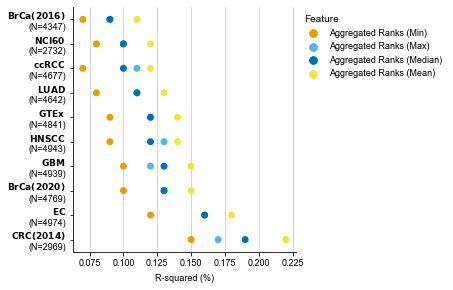

In [17]:
get_order = lambda df: df.groupby(by=['Data']).sum().sort_values('R-squared').index.values
palette = [gu.get_color(x) for x in ['orange', 'sky-blue', 'blue', 'yellow', 'green']]
with plt.rc_context({'axes.linewidth': 0.8, 'axes.spines.left': True}):
    figure, ax = plt.subplots(1, 1, figsize=(4, 4.5))
    customized_plots.draw_dotplot(ax=ax, x='R-squared', y='Data', data=r2_internalRanks_all, hue='Factor',  
                                  order=get_order(r2_internalRanks_all),
                                  args=gu.additional_plot_parameters(xlab="R-squared (%)", ylab=None, 
                                                                     yaxis_grid=False, xaxis_grid=True,  
                                                                     palette=palette,
                                                                     anchor_legend_at=(1, 1)))

<div class="alert alert-block alert-warning">
<b>Note:</b> The Aggregated Reproducibility Rank (Mean) explains the variation in mRNA-protein correlation better than the other internal ranking methods. Henceforth, we will be considering Aggregated Reproducibility Rank (Mean) for all our analyses.
</div>

### Other Rank Aggregation Algorithms

In [18]:
file_rra = get_local_data_path(['processed', 'rank_aggregation'], 'RRA.csv')
file_markov_aggregator = get_local_data_path(['processed', 'rank_aggregation'], 'markov_aggregator.csv')

#### Robust Rank Aggregation and Stuart (implemented in R)

In [19]:
rra = pd.read_csv(file_rra, index_col=0)
print('Dimensions: ', rra.shape)
rra[:2]

Dimensions:  (7776, 6)


,RRA,Stuart,Mean,Median,Min,Geom_Mean
ALDH2,0.000028,0.000002,0.001771,0.019155,0.001732,0.008856
MVP,0.000037,0.000001,0.004242,0.002032,0.000866,0.006829


**Markov Chain Aggregator**

In [20]:
# # Implementation of Markov Chain Aggregator 4 Algo to compute ranks - NOTE: takes a long time run

# from mc4.algorithm import mc4_aggregator

# ranks = pd.concat([replicates_correlation_ov.rank(ascending=False),
#            replicates_correlation_ccle.rank(ascending=False),
#            replicates_correlation_colon.rank(ascending=False)], axis=1)
# ranks.columns = ['OV Rank', 'CCLE Rank', 'Colon Rank']
# ranks.dropna(thresh=0.66*len(ranks.columns), inplace=True)
# ranks = ranks[['OV Rank','CCLE Rank', 'Colon Rank']].fillna(value=0)
# ranks[:2]

# mc_ranks = ranks.copy(deep=True)
# mc_ranks.dropna(inplace=True)

# aggregated_mc_ranks = mc4_aggregator(mc_ranks, header_row = 0, index_col = 0) 

# markov_chain_aggregator = pd.DataFrame.from_dict(aggregated_mc_ranks, orient='index')
# markov_chain_aggregator.columns = ['MC4']
# markov_chain_aggregator[:2]
# markov_chain_aggregator.to_csv(file_markov_aggregator)

In [21]:
markov_chain_aggregator = pd.read_csv(file_markov_aggregator, index_col=0)
markov_chain_aggregator[:2]

,MC4
A1BG,666
A2M,3787


**BordaFuse**

In [22]:
inverse_ranks = pd.concat([len(replicates_correlation_ov) - replicates_correlation_ov.rank(ascending=False),
                           len(replicates_correlation_ccle) - replicates_correlation_ccle.rank(ascending=False),
                           len(replicates_correlation_colon) - replicates_correlation_colon.rank(ascending=False)], axis=1)
inverse_ranks.columns = ['OV Rank', 'CCLE Rank', 'Colon Rank']
inverse_ranks[:2]

,OV Rank,CCLE Rank,Colon Rank
A1BG,4462.5,NaN,1349.0
A2M,5099.0,1550.5,1176.0


In [23]:
inverse_ranks.dropna(thresh=0.66*len(inverse_ranks.columns), inplace=True)
inverse_ranks['BordaFuse'] = inverse_ranks.sum(axis=1)
inverse_ranks[:2]

,OV Rank,CCLE Rank,Colon Rank,BordaFuse
A1BG,4462.5,NaN,1349.0,5811.5
A2M,5099.0,1550.5,1176.0,7825.5


Combining all the ranks from different external rank aggregation algorithms into one dataframe with common proteins

In [24]:
# Finding common indices between all the required ranking algorithms
all_ranks  = pd.concat([rra[['RRA', 'Stuart']], inverse_ranks['BordaFuse'], 
                        markov_chain_aggregator['MC4'], aggregated_normalized_ranks_mean], axis=1, join='inner')
all_ranks[:2]

,RRA,Stuart,BordaFuse,MC4,Aggregated Reproducibility Rank (Mean)
ALDH2,0.000028,0.000002,15425.0,13,0.985528
MVP,0.000037,0.000001,15082.5,26,0.939184


In [25]:
assert(all_ranks.isnull().sum().sum() == 0)

In [26]:
r2_rra_all = {} ; r2_stuart_all = {} ; r2_bordafuse_all = {}; r2_mc4_all = {} ; r2_ag_mean_all = {}

for study in all_studies: 
    r2_rra_all[study.name] = round(ols_fit(x=all_ranks['RRA'], y = study).rsquared_adj* 100, 2)
    r2_stuart_all[study.name] = round(ols_fit(x=all_ranks['Stuart'], y = study).rsquared_adj* 100, 2)
    r2_bordafuse_all[study.name] = round(ols_fit(x=all_ranks['BordaFuse'], y = study).rsquared_adj* 100, 2)
    r2_mc4_all[study.name] = round(ols_fit(x=all_ranks['MC4'], y = study).rsquared_adj* 100, 2)
    r2_ag_mean_all[study.name] = round(ols_fit(x=all_ranks['Aggregated Reproducibility Rank (Mean)'], 
                                           y = study).rsquared_adj* 100, 2)

In [27]:
r2_rra_replicates = {} ; r2_stuart_replicates = {} ; r2_bordafuse_replicates = {}; 
r2_mc4_replicates = {} ; r2_ag_mean_replicates = {}

for study in replicate_studies: 
    r2_rra_replicates[study.name] = round(ols_fit(x=all_ranks['RRA'], y = study).rsquared_adj * 100, 2)
    r2_stuart_replicates[study.name] = round(ols_fit(x=all_ranks['Stuart'], y = study).rsquared_adj* 100, 2)
    r2_bordafuse_replicates[study.name] = round(ols_fit(x=all_ranks['BordaFuse'], y = study).rsquared_adj* 100, 2)
    r2_mc4_replicates[study.name] = round(ols_fit(x=all_ranks['MC4'], y = study).rsquared_adj* 100, 2)
    r2_ag_mean_replicates[study.name] = round(ols_fit(x=all_ranks['Aggregated Reproducibility Rank (Mean)'], 
                                           y = study).rsquared_adj* 100, 2)

In [28]:
proteins_count = {study.name: len(all_ranks[all_ranks.index.isin(study.index)]) for study in all_studies}
r2_externalRanks_all = cu.dataframe_from_dict(['RRA', 'Stuart','BordaFuse', 'MC4', 
                                               'Average\nnormalized rank', 'Proteins count'], 
                                              r2_rra_all,  r2_stuart_all, r2_bordafuse_all,
                                              r2_mc4_all, r2_ag_mean_all, proteins_count, repeat_factor=len(r2_rra_all))

Factor,Data,Average normalized rank,BordaFuse,MC4,RRA,Stuart,Proteins count
0,BrCa (2016),10.63,10.35,7.94,8.18,9.77,4344
1,BrCa (2020),15.35,11.80,13.96,12.99,12.85,4763
2,CRC (2014),21.65,18.37,13.48,17.73,18.09,2967
3,EC,18.02,13.80,16.31,15.57,14.86,4969
4,GBM,14.76,12.78,12.54,12.31,13.40,4933
5,GTEx,14.30,14.19,10.13,11.27,12.20,4834
6,HNSCC,14.09,12.35,11.61,10.65,12.99,4938
7,LUAD,12.84,12.27,9.80,9.59,11.91,4636
8,NCI60,12.18,14.87,7.88,9.49,10.85,2731
9,ccRCC,11.69,9.94,10.92,10.24,10.36,4671


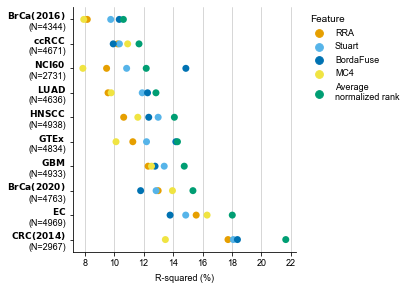

In [29]:
get_order = lambda df: df.groupby(by=['Data']).sum().sort_values('R-squared').index.values
with plt.rc_context({'axes.linewidth': 0.8, 'axes.spines.left': True}):
    figure, ax = plt.subplots(1, 1, figsize=(4, 4.5))
    customized_plots.draw_dotplot(ax=ax, x='R-squared', y='Data', data=r2_externalRanks_all, hue='Factor',  
                                  order=get_order(r2_externalRanks_all),
                                  args=gu.additional_plot_parameters(xlab="R-squared (%)", ylab=None, 
                                                                     yaxis_grid=False, xaxis_grid=True,  
                                                                     palette=palette,
                                                                     anchor_legend_at=(1.5, 1)))

In [30]:
proteins_count = {study.name: len(all_ranks[all_ranks.index.isin(study.index)]) for study in replicate_studies}
r2_externalRanks_replicates = cu.dataframe_from_dict(['RRA', 'Stuart','BordaFuse', 'MC4', 
                                                   'Average\nNormalized Ranks', 'Proteins count'],
                                                  r2_rra_replicates,  r2_stuart_replicates, 
                                                  r2_bordafuse_replicates, r2_mc4_replicates, r2_ag_mean_replicates,
                                                  proteins_count, repeat_factor=len(r2_rra_replicates))

Factor,Data,Average Normalized Ranks,BordaFuse,MC4,RRA,Stuart,Proteins count
0,CCLE,24.05,21.43,23.99,21.18,19.74,4767
1,Colon,16.99,13.41,10.14,14.06,14.33,4220
2,Ovarian,19.76,21.60,11.89,14.43,18.39,4581


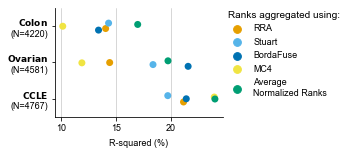

In [31]:
get_order = lambda df: df.groupby(by=['Data']).sum().sort_values('R-squared').index.values
with plt.rc_context({'axes.linewidth': 0.8, 'axes.spines.left': True}):
    figure, ax = plt.subplots(1, 1, figsize=(3, 2))
    customized_plots.draw_dotplot(ax=ax, x='R-squared', y='Data', data=r2_externalRanks_replicates, hue='Factor',  
                                  order=get_order(r2_externalRanks_replicates),
                                  args=gu.additional_plot_parameters(xlab="R-squared (%)", ylab=None, 
                                                                     yaxis_grid=False, xaxis_grid=True,  
                                                                     palette=palette,
                                                                     anchor_legend_at=(6, 1.05)), jitter=0.12)
    ax.legend(title='Ranks aggregated using:', title_fontsize='medium', facecolor='white', framealpha=1,
              bbox_to_anchor = (1.75, 1.05))._legend_box.align = "left"
#     figure.savefig('../figures/S2B.svg', bbox_inches='tight', dpi=300)

<div class="alert alert-block alert-success">
Our internal method of Aggregated Reproducibility Rank ('Average normalized rank') has outperformed the other algorithms in explaining the variation in mRNA-protein correlation of the studies containing proteomic replicates or otherwise (see previous diagram for reference) 
</div>

In [32]:
ranks = pd.concat([get_normalized_ranks(replicates_correlation_ov), get_normalized_ranks(replicates_correlation_colon), 
           get_normalized_ranks(replicates_correlation_ccle), aggregated_normalized_ranks_mean], axis=1)
ranks.columns = ['Ovarian Reproducibility Rank', 'Colon Reproducibility Rank', 'CCLE Reproducibility Rank', 
                'Aggregated Reproducibility Rank']

In [33]:
sheets = ['A. Protein-protein correlation', 'B. Protein reproducibility rank']
writer = pd.ExcelWriter(file_protein_reproducibility)
replicate_cor.to_excel(writer, sheets[0])
ranks.to_excel(writer, sheets[1])

writer.sheets[sheets[0]].set_column('B:D', 15)
writer.sheets[sheets[1]].set_column('B:E', 25)
writer.save()

In [34]:
# Combining ranks and ensuring that the comparison per study in all the ranks contains the same number of proteins
combined_ranks = ranks.dropna()

In [35]:
rsquared_ov = {}
print("Regressing mRNA-protein correlation using OV")
for study in all_studies: 
    rsquared_ov[study.name] = round(ols_fit(x=combined_ranks[ranks.columns[0]], 
                                            y = study).rsquared_adj*100, 2)
    
rsquared_colon = {}
print("Regressing mRNA-protein correlation using Colon")
for study in all_studies: 
    rsquared_colon[study.name] = round(ols_fit(x=combined_ranks[ranks.columns[1]], 
                                               y = study).rsquared_adj*100, 2)
    
rsquared_ccle = {}
print("Regressing mRNA-protein correlation using CCLE")
for study in all_studies: 
    rsquared_ccle[study.name] =round(ols_fit(x=combined_ranks[ranks.columns[2]], 
                                             y = study).rsquared_adj *100, 2)
    
    
rsquared_aggregated_rank = {}
print("Regressing mRNA-protein correlation using Aggregated Rank")
for study in all_studies: 
    rsquared_aggregated_rank[study.name] = round(ols_fit(x=combined_ranks[ranks.columns[3]], 
                                               y = study).rsquared_adj*100, 2)

Regressing mRNA-protein correlation using OV
Regressing mRNA-protein correlation using Colon
Regressing mRNA-protein correlation using CCLE
Regressing mRNA-protein correlation using Aggregated Rank


In [36]:
proteins_count = {study.name: len(combined_ranks[combined_ranks.index.isin(study.index)]) for study in all_studies}
rsquared_ranks = cu.dataframe_from_dict(['Ovarian Protein\nReproducibility Rank', 'CCLE Protein\nReproducibility Rank', 
                                         'Colon Protein\nReproducibility Rank', 
                                         'Aggregated Protein\nReproducibility Rank', 'Proteins count'], 
                                         rsquared_ov, rsquared_ccle, rsquared_colon, rsquared_aggregated_rank,
                                         proteins_count, repeat_factor=len(rsquared_ov))

Factor,Data,Aggregated Protein Reproducibility Rank,CCLE Protein Reproducibility Rank,Colon Protein Reproducibility Rank,Ovarian Protein Reproducibility Rank,Proteins count
0,BrCa (2016),14.16,8.10,7.47,7.05,2285
1,BrCa (2020),21.65,12.60,13.26,9.35,2489
2,CRC (2014),24.14,8.85,21.02,11.22,2299
3,EC,26.50,13.96,16.64,12.76,2615
4,GBM,19.67,12.17,9.82,10.24,2600
5,GTEx,20.26,13.37,9.31,10.38,2602
6,HNSCC,20.32,13.33,10.99,8.98,2613
7,LUAD,19.44,11.71,10.55,9.10,2424
8,NCI60,14.04,12.02,3.34,9.09,2024
9,ccRCC,15.61,11.22,6.95,7.47,2512


In [37]:
xlab="R-squared (%)"
palette = [gu.get_color(x) for x in ['orange', 'yellow', 'sky-blue', 'green']]
args=gu.additional_plot_parameters(xlab=xlab, ylab=None, yaxis_grid=False, xaxis_grid=True,  
                                   palette= palette, #['#E69F00', '#009E73'], 
                                   anchor_legend_at=(1.5, 1))

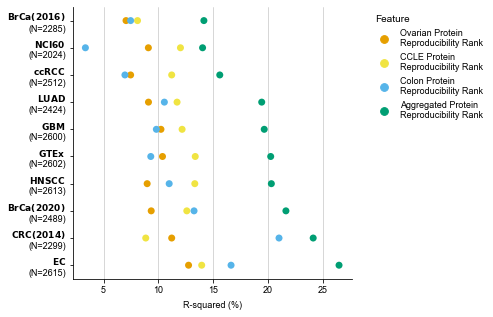

In [38]:
get_order = lambda df: df.groupby(by=['Data']).sum().sort_values('R-squared').index.values
hue_order = ['Ovarian Protein\nReproducibility Rank', 'CCLE Protein\nReproducibility Rank', 
             'Colon Protein\nReproducibility Rank', 'Aggregated Protein\nReproducibility Rank']
with plt.rc_context({'axes.linewidth': 0.8, 'axes.spines.left': True}):
    figure, ax = plt.subplots(1, 1, figsize=(5, 5))
    args.palette =  ['#009E73' if color == '#999999' else color for color in palette]
    customized_plots.draw_dotplot(ax=ax, x='R-squared', y='Data', data=rsquared_ranks, hue='Factor',
                                  order=get_order(rsquared_ranks), args=args, hue_order=hue_order)

#     figure.savefig('../figures/S3.svg', bbox_inches='tight', dpi=300)